In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

First, go and simulate some (income) data. Here, I use a Weibull distribution to draw from and bin the data it into 20 income brackets. Bracketed data formats are frequently found in income survey data.


In [32]:
nbrackets = 10
wb = 10000*np.random.weibull(1.5, 1000)
rounded_max = round(wb.max())
brackets = np.array([ x for x in range(0, rounded_max, round(rounded_max/nbrackets))])
wb_brackets_index = np.digitize(wb, brackets)
brackets[wb_brackets_index-1]
simulated_data = pd.DataFrame({"weibull": wb, "weibull_bracketed": brackets[wb_brackets_index-1]})

Also plot the simulated data.

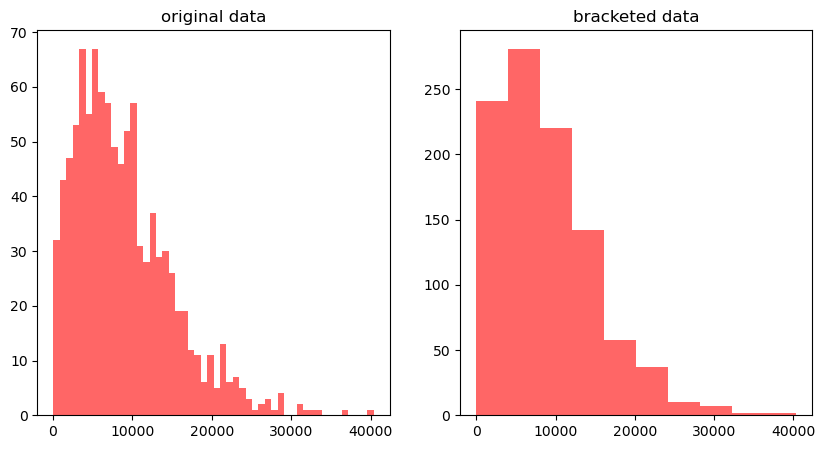

In [33]:
num_rows, num_cols = 1, 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(10, 5))
ax[0].hist(wb, bins=50, color="red", alpha = 0.6)
ax[0].set(title="original data")
ax[1].hist(simulated_data["weibull_bracketed"], bins=nbrackets, color="red", alpha = 0.6)
ax[1].set(title="bracketed data")
plt.show()

0       9855
1       7884
2      11826
3      11826
4          0
       ...  
995    15768
996        0
997     9855
998     3942
999    17739
Name: weibull_bracketed, Length: 1000, dtype: int64

Now, write a function that takes as input some moment conditions and returns a maximum entropy distribution that satisfies those.

In [513]:
from math import exp, cos, sin, sinh, tan, tanh, log, sqrt, pi
from scipy import integrate
def phi1(x):
    phi1 = np.log(x)
    return phi1

def phi2(x):
    phi2 = np.log(x)**2
    return phi2

def phi3(x):
    phi3 = log(1+x)
    return phi3

def get_f(mu, support):
    
    # make the exponential-part of the distribution (string expression)
    string = list("exp( (-1)*( 0 ")
    for i in range(0, len(mu)):
        if not mu[i]==0 :
            lst = [" + ", str(mu[i]), "*phi", str(i+1), "(x)"]
        string.extend(lst)
    string.append(" ) )")    
    f_string = "".join(string)
    
    # normalize the distribution
    omega = integrate.quad(
            lambda x: eval(f_string),  
        support[0], 
        support[1])[0]
    def f(x):
        """ maximum entropy distribution with natural parameter vector mu (fixed)

        Args:
            x (num): ME distribution to be evauated at x

        Returns:
            f(x) (num): value of ME distribution at x 
        """
        
        if x >= support[0] and x <= support[1]:
            return eval(f_string)/omega
        else:
            return 0
        return val
    
    return f

def eval_f(x, mu, PHI, support):
    """_summary_

    Args:
        x (nparray): point at which to evaluate the ME distribution
        mu (tuple): vector of natural parameters
        PHI (fun): vector of functions
        support (num): interval

    Returns:
        f(x) (nparray): values of ME distribution at x
    """
    
    # might want to replace the numeric integration here by some fast monte carlo integration
    omega = integrate.quad(
            lambda x : exp( - np.matrix(mu) * np.matrix(PHI(x)).transpose()),  
        support[0], 
        support[1])[0]    
    
    filter = tuple([(x > support[0]) & (x < support[1])])
    y = np.zeros(len(x))
    y1 = np.exp( - np.matrix(mu) * PHI(np.array(x[filter])) )
    y[filter] = np.ravel(y1)
    return y/omega

def log_lhood(mu, y_obs, PHI, support) : 
    omega = integrate.quad(
            lambda x : exp( - np.matrix(mu) * np.matrix(PHI(x)).transpose()),  
        support[0], 
        support[1])[0]  
    y = - log(omega) - np.matrix(mu) * PHI(np.array(y_obs)) 
    lhood = np.sum(y)
    return -lhood


In [519]:
# calculate a likelihood: trial run.
import time
yobs = np.array(simulated_data["weibull"]/10000)

tic = time.perf_counter()
log_lhood((1,1), yobs, PHI, (0, 100000))
toc = time.perf_counter()
print(f"lhood function calculates in {toc-tic:0.4f} seconds")

# find mle using nelder-mead
toc = time.perf_counter()
mlhood_nm = optimize.minimize(log_lhood, (1,1), args=(yobs, PHI, (0.01, 10000)), method="Nelder-Mead")
toc = time.perf_counter()
print(f"Nelder-Mead calculates in {toc-tic:0.4f} seconds")

# find mle using bfgs
toc = time.perf_counter()
mlhood_bfgs = optimize.minimize(log_lhood, (1,1), args=(yobs, PHI, (0.01, 10000)), method="L-BFGS-B")
print(f"BFGS calculates in {toc-tic:0.4f} seconds")

lhood function calculates in 0.0145 seconds


 final_simplex: (array([[1.52136169, 0.6175258 ],
       [1.52126295, 0.61751291],
       [1.52138255, 0.61757681]]), array([891.27134911, 891.27134917, 891.27135066]))
           fun: 891.2713491119196
       message: 'Optimization terminated successfully.'
          nfev: 63
           nit: 32
        status: 0
       success: True
             x: array([1.52136169, 0.6175258 ])
      fun: 891.2713483340881
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.27373677e-05,  2.27373674e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([1.5213133 , 0.61751954])


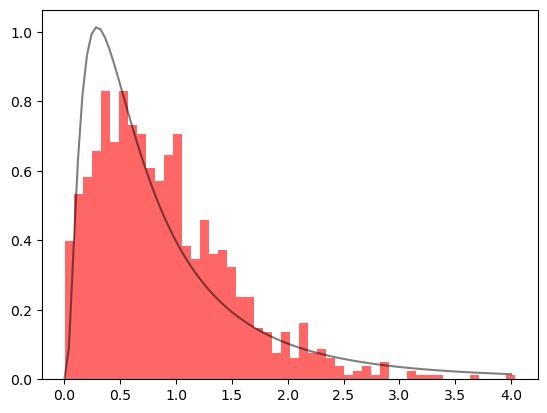

In [532]:
# print results
print(mlhood_nm)
print(mlhood_bfgs)

# plot estimated density on top of histogram
mu = mlhood_bfgs.x
grid = np.linspace(0,4,100)

fig, ax = plt.subplots()
ax.hist(yobs, bins = 50, color='red', alpha = 0.6, density = True)
ax.plot(grid, eval_f(grid, mu, PHI, (0,np.inf)), color="black", alpha=0.5)

plt.show()


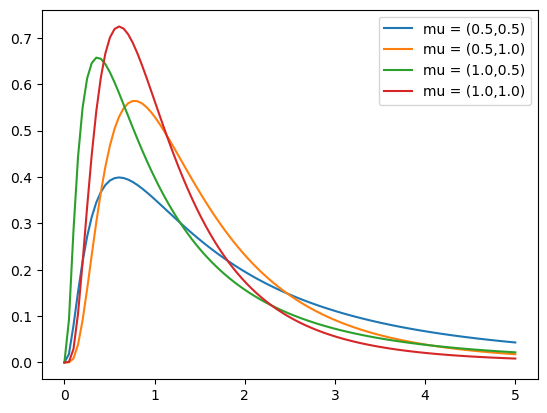

In [452]:
# SANDBOX ############
def PHI(x):
    return np.matrix([phi1(x), phi2(x)])

x = np.linspace(0, 5, 100)
Y = pd.DataFrame({"x": x})

fig, ax = plt.subplots()
for i in [x/2 for x in range(1, 3, 1)]:
    for j in [x/2 for x in range(1, 3, 1)]:
        mu = (i,j)
        y = 0
        y = eval_f(x, mu, PHI, (0, np.inf))
        lab = "mu = (" + str(i) + "," + str(j) + ")"
        Y[lab] = y
        ax.plot(x, y, label = lab)
Y
ax.legend()
plt.show()

# x = np.linspace(-1, 4, 1000)
# delta = x[1] - x[0]
# y = eval_f(x, mu, PHI, (0, np.inf))

# # approximate integral
# print(np.sum(y)*delta)

# # exact integral
# integrate.quad(
#     lambda x : eval_f(np.array([x]), mu, PHI, (0, np.inf))[0],
#     -np.inf,
#     np.inf)